In [2]:
import pandas as pd
import json
import os
import regex as re

In [30]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.3.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e6c43c1f-1502-40f3-a06c-d2029996babd;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 478ms :: artifacts dl 48ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

23/11/20 14:44:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


3.3.0


In [5]:
cwd = os.getcwd()
print(cwd)

/root/fall-2023-reddit-project-team-17/code/project-nlp


In [6]:
!aws s3 ls s3://project17-bucket-alex

                           PRE books/
                           PRE flairs/
                           PRE lab8/
                           PRE matt-comment-subreddit-counts/
                           PRE matt-submission-subreddit-counts/
                           PRE matt-submissions-age-gender/
                           PRE project_2022/
                           PRE project_2022_1/
                           PRE project_2022_10/
                           PRE project_2022_11/
                           PRE project_2022_12/
                           PRE project_2022_2/
                           PRE project_2022_3/
                           PRE project_2022_4/
                           PRE project_2022_5/
                           PRE project_2022_6/
                           PRE project_2022_7/
                           PRE project_2022_8/
                           PRE project_2022_9/
                           PRE project_jan2021/
                           PRE spark_lo

In [7]:
!aws s3 ls s3://project17-bucket-alex/project_2022_1/

                           PRE comments/
                           PRE submissions/


In [8]:
!aws s3 ls s3://project17-bucket-alex/project_jan2021/

                           PRE comments/
                           PRE submissions/


In [12]:
%%time
# Read in data from project bucket
bucket = "project17-bucket-alex"
#output_prefix_data = "project_2022"

# List of 12 directories each containing 1 month of data
directories = ["project_2022_"+str(i)+"/submissions" for i in range(1,13)]

# Iterate through 12 directories and merge each monthly data set to create one big data set
df_subs = None
for directory in directories:
    s3_path = f"s3a://{bucket}/{directory}"
    month_df = spark.read.parquet(s3_path, header = True)
    
    if df_subs is None:
        df_subs = month_df
    else:
        df_subs = df_subs.union(month_df)

CPU times: user 12.3 ms, sys: 9.57 ms, total: 21.9 ms
Wall time: 9.06 s


In [13]:
%%time
# Read in data from project bucket
bucket = "project17-bucket-alex"
#output_prefix_data = "project_2022"

# List of 12 directories each containing 1 month of data
directories = ["project_2022_"+str(i)+"/comments" for i in range(1,13)]

# Iterate through 12 directories and merge each monthly data set to create one big data set
df_comms = None
for directory in directories:
    s3_path = f"s3a://{bucket}/{directory}"
    month_df = spark.read.parquet(s3_path, header = True)
    
    if df_comms is None:
        df_comms = month_df
    else:
        df_comms = df_comms.union(month_df)

CPU times: user 15.5 ms, sys: 3.15 ms, total: 18.7 ms
Wall time: 7.58 s


In [14]:
no_stupid_questions_df = df_comms.filter(df_comms['subreddit'] == 'NoStupidQuestions')

In [15]:
no_stupid_questions_df.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



In [18]:
no_stupid_questions_df.select(['subreddit', 'body', 'created_utc']).show(5)

+-----------------+--------------------+-------------------+
|        subreddit|                body|        created_utc|
+-----------------+--------------------+-------------------+
|NoStupidQuestions|You couldn't heat...|2022-01-10 04:49:57|
|NoStupidQuestions|it wouldn't taste...|2022-01-10 04:49:57|
|NoStupidQuestions|                Meow|2022-01-10 04:50:00|
|NoStupidQuestions|            To agree|2022-01-10 04:50:04|
|NoStupidQuestions|Yep. I’ve had two...|2022-01-10 04:50:10|
+-----------------+--------------------+-------------------+
only showing top 5 rows



In [18]:
no_stupid_questions_df.select(['subreddit', 'body', 'created_utc']).show(5)

+-----------------+--------------------+-------------------+
|        subreddit|                body|        created_utc|
+-----------------+--------------------+-------------------+
|NoStupidQuestions|You couldn't heat...|2022-01-10 04:49:57|
|NoStupidQuestions|it wouldn't taste...|2022-01-10 04:49:57|
|NoStupidQuestions|                Meow|2022-01-10 04:50:00|
|NoStupidQuestions|            To agree|2022-01-10 04:50:04|
|NoStupidQuestions|Yep. I’ve had two...|2022-01-10 04:50:10|
+-----------------+--------------------+-------------------+
only showing top 5 rows



In [20]:
from pyspark.sql.functions import length, col
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# find longer questions
word_threshold = 50
long_questions_df = no_stupid_questions_df.filter(length(col("body")) > word_threshold)

# find covid related words
keywords = ["covid", "vaccine", "coronavirus", "pandemic", 'corona', 'covid-19', 'vaccination', 'Pfizer', 'Moderna', 'Novavax']
covid_questions_df = long_questions_df.filter(
    long_questions_df.body.rlike("|".join(keywords))
)

# Tokenize 
tokenizer = Tokenizer(inputCol="body", outputCol="words")
tokenized_df = tokenizer.transform(covid_questions_df)

#remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_df = remover.transform(tokenized_df)

In [22]:
filtered_df.select(['subreddit', 'body', 'created_utc']).show(5)

+-----------------+--------------------+-------------------+
|        subreddit|                body|        created_utc|
+-----------------+--------------------+-------------------+
|NoStupidQuestions|I think part of i...|2022-01-10 04:53:12|
|NoStupidQuestions|Hello /u/Worldvie...|2022-01-10 04:57:06|
|NoStupidQuestions|Pfft lonely for 3...|2022-01-08 06:32:47|
|NoStupidQuestions|Hello /u/Low-Love...|2022-01-21 05:15:05|
|NoStupidQuestions|Isn’t the vaccine...|2022-01-21 05:15:14|
+-----------------+--------------------+-------------------+
only showing top 5 rows



In [23]:
num_rows = filtered_df.count()
num_columns = len(filtered_df.columns)

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)


Number of rows: 31275
Number of columns: 23


In [ ]:
# out_path = "s3a://project17-bucket-alex/covid-no-stupid-questions.parquet"
# filtered_df.write.parquet(out_path)

In [25]:
from pyspark.sql.functions import to_date
from pyspark.sql import functions as F

filtered_df_with_date = filtered_df.withColumn("date", to_date("created_utc"))

filtered_counts = filtered_df_with_date.groupBy("date").agg(F.count("id").alias("post_count"))

ordered_df = filtered_counts.orderBy("date")


In [26]:
datewise_counts_pd = ordered_df.toPandas()

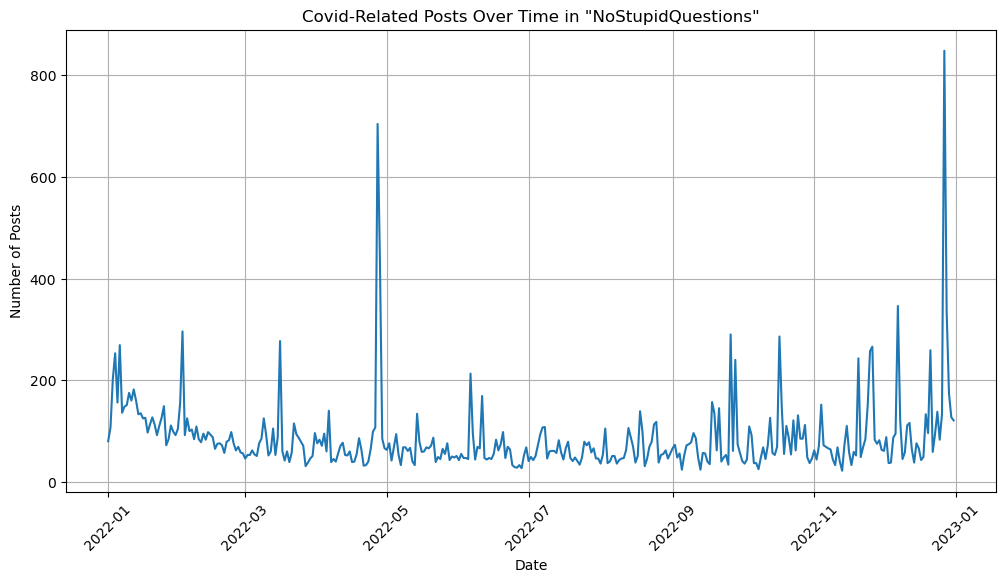

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(datewise_counts_pd['date'], datewise_counts_pd['post_count'], linestyle='-')
plt.title('Covid-Related Posts Over Time in "NoStupidQuestions"')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.grid(True)
path = '../../website-source/img/nlp-plots/covid-nsq.png'
plt.savefig(path)
plt.show()

In [34]:
!aws s3 ls s3://project17-bucket-alex

                           PRE books/
                           PRE covid-no-stupid-questions.parquet/
                           PRE flairs/
                           PRE lab8/
                           PRE matt-comment-subreddit-counts/
                           PRE matt-submission-subreddit-counts/
                           PRE matt-submissions-age-gender/
                           PRE project_2022/
                           PRE project_2022_1/
                           PRE project_2022_10/
                           PRE project_2022_11/
                           PRE project_2022_12/
                           PRE project_2022_2/
                           PRE project_2022_3/
                           PRE project_2022_4/
                           PRE project_2022_5/
                           PRE project_2022_6/
                           PRE project_2022_7/
                           PRE project_2022_8/
                           PRE project_2022_9/
                     